In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
# Step 1. Create a model (Feedforward Neural Network)
# Three-layer fully connected neural network with 32 nodes in each layer
n_nodes = 32
n_out = 1
model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_nodes, activation="tanh"),
    tf.keras.layers.Dense(n_out, activation=None) # linear activation
])

In [ ]:
# Step 2: Construct loss function
u0 = 1 # initial condition
u_t0 = 0 # initial condition

def loss(model, X_PDE, X_IC):
    with tf.GradientTape(persistent=True) as g:
        g.watch(X_PDE)
        u = model(X_PDE)
        u_t = g.gradient(u, X_PDE)[:, 0:1]
        u_tt = g.gradient(u_t, X_PDE)[:, 0:1]


    loss_PDE = tf.reduce_mean((u_tt + mu*u_t + k*u)**2)

    # Calculate loss of IC
    loss_IC_ = tf.reduce_mean((model(X_IC) - u0)**2)
    with tf.GradientTape() as g2:
        g2.watch(X_IC)
        uc = model(X_IC)
    uc_t = g2.gradient(uc, X_IC)[:, 0:1]
    loss_IC_t = tf.reduce_mean((uc_t - u_t0)**2)

    w1 = 1e-1
    w2 = 1e-4

    loss_IC = loss_IC_ + w1*loss_IC_t

    # Total loss
    loss_total = w2*loss_PDE + loss_IC

    return loss_total, loss_PDE, loss_IC

In [ ]:
def IC_data(Nx):
    # for the initial condition data, t=0
    t = np.zeros((Nx, 1))
    return tf.constant(t, dtype=tf.float32)

def PDE_data(Np):
    t = np.random.rand(Np, 1) # t  is over the domaine of [0,1]
    return tf.constant(t, dtype=tf.float32)

In [ ]:
# Step 3.0. Generate training data
d, w0 = 2, 20
mu, k = 2*d, w0**2


Nx = 300  # number of training data for IC
Np = 300  # number of training data for PDE


X_IC = IC_data(Nx)
X_PDE = PDE_data(Np)

# Create a dataset object for X_PDE
X_PDE_dataset = tf.data.Dataset.from_tensor_slices(X_PDE)
# Shuffle and batch data
X_PDE_dataset = X_PDE_dataset.shuffle(buffer_size=Np).batch(256)

In [ ]:
# Step 3.1. Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# Step 3.2. Define training loop
epochs = 5000
# loop over epochs, each epoch contains all batches, each batch contains batch_size data
# read data from X_PDE_dataset
for epoch in range(epochs):
    for X_PDE_batch in X_PDE_dataset:
        with tf.GradientTape() as g:
            # calculate loss
            loss_total, loss_PDE, loss_IC = loss(model, X_PDE_batch, X_IC)

        # calculate gradient
        grads = g.gradient(loss_total, model.trainable_variables)
        # update weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if (epoch+1) % 500 == 0:
        print('Epoch: %d, Loss: %f, Loss_PDE: %f, Loss_IC: %f' \
            % (epoch+1, loss_total, loss_PDE, loss_IC))

Epoch: 500, Loss: 0.004645, Loss_PDE: 11.869741, Loss_IC: 0.003458
Epoch: 1000, Loss: 0.000977, Loss_PDE: 9.408268, Loss_IC: 0.000036
Epoch: 1500, Loss: 0.001180, Loss_PDE: 9.250989, Loss_IC: 0.000255
Epoch: 2000, Loss: 0.001202, Loss_PDE: 3.181925, Loss_IC: 0.000884
Epoch: 2500, Loss: 0.001392, Loss_PDE: 12.198655, Loss_IC: 0.000172
Epoch: 3000, Loss: 0.002291, Loss_PDE: 3.012163, Loss_IC: 0.001990
Epoch: 3500, Loss: 0.000658, Loss_PDE: 4.458177, Loss_IC: 0.000212
Epoch: 4000, Loss: 0.022138, Loss_PDE: 187.165878, Loss_IC: 0.003422
Epoch: 4500, Loss: 0.002185, Loss_PDE: 17.300425, Loss_IC: 0.000455
Epoch: 5000, Loss: 0.001226, Loss_PDE: 6.486952, Loss_IC: 0.000578


In [ ]:
def plot_2D(xlim=None, ylim=None, xticks=None, yticks=None,
            xlabel = 'x', ylabel = 'y',
            figsize=(7.3, 5.9), label_size=18, tick_size=16, spine_width=1.5):

    fig, ax = plt.subplots(figsize=figsize)

    #-----Format Axis ---------------------------
    # labels and size
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)

    # limits, ticks and size
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)

    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    for tick in ax.get_xticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)
    for tick in ax.get_yticklabels():
        #tick.set_fontname('Times New Roman')
        tick.set_fontsize(tick_size)

    #---------- Spines -------
    ax.spines["top"].set_linewidth(spine_width)
    ax.spines["left"].set_linewidth(spine_width)
    ax.spines["right"].set_linewidth(spine_width)
    ax.spines["bottom"].set_linewidth(spine_width)

    return fig, ax

In [ ]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    # cos = torch.cos(phi+w*t)
    # exp = torch.exp(-d*t)
    u = np.exp(-d*t)*2*A*np.cos(phi+w*t)
    return u

In [ ]:
def plot_solutions(model, d= 2, w0= 20, x_range=(0, 1)):
    """
    Plots the exact solution and the PINN solution.

    Args:
        model: The trained PINN model.
        d: Damping coefficient for the exact solution.
        w0: Natural frequency for the exact solution.
        x_range: A tuple specifying the range for the x-axis (time).
    """
    x = np.linspace(x_range[0], x_range[1], 200)
    X_inp = tf.constant(x.reshape(-1, 1), dtype=tf.float32)

    # Get PINN prediction
    u_pred = model(X_inp).numpy()

    # Get exact solution
    u_exact = exact_solution(d, w0, x)

    fig, ax = plot_2D(xlim=x_range, ylim=[-1.1, 1.1], xticks=np.linspace(x_range[0], x_range[1], 3),
                      yticks=[-1, 0, 1], xlabel='$t$', ylabel='$u(t)$')

    ax.plot(x, u_pred, 'ro', markevery=2, markersize=5, label='PINN Solution')
    ax.plot(x, u_exact, 'k', linewidth=2, alpha=0.5, label='Exact Solution')

    ax.legend(fontsize='large', loc='best')
    plt.show()

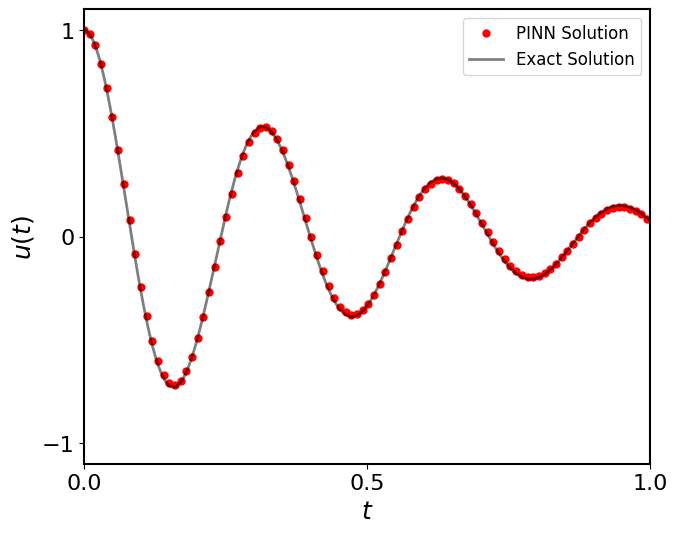

In [ ]:
plot_solutions(model)